## Stock Price Prediction Using Recurrent Neural Networks

Floating assignment 2

Gabor Kovacs | CAP 6635 | 3/28/2020

# Introduction

What follows is a python program which I adapted from a number of online tutorials.  My goal was to gain a good understanding of recurrent neural networks, specifically the LSTM layer, understand each line of code in the tutorials, and to add comments to anything that was unclear to me.

The program allows you to input a stock ticker, VDE (an ETF) in this case – an ETF is basically a basket of stocks, oil related companies in this case.  VDE has data starting from around 2004 so there is plenty to train with.  The details of each step are below, but the basic idea is, we look at the last 60 days&#39; worth of closing prices – the price at which the stock closed at for the particular day, then we use the 61st  day as the label for training.

Of course, this is a very naïve approach to stock investing.  If predicting the price of a stock was as simple as looking at past data, I think every CS student would be rich by now. In addition to past data, perhaps adding Sentiment Analysis might start to give us more realistic predictions, although that is also questionable. 

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential, load_model


C:\Users\Gabor\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
rawDataDF = web.DataReader('VDE', data_source='yahoo', start='2000-01-01',end='2020-03-27')
#rawDataDF = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01',end='2019-12-17')


In [3]:
rawDataDF


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-09-29,50.520000,49.970001,50.369999,49.970001,900.0,36.547981
2004-09-30,50.439999,50.250000,50.439999,50.419998,4500.0,36.877110
2004-10-01,51.090000,50.450001,50.450001,51.070000,6700.0,37.352524
2004-10-04,51.240002,51.009998,51.099998,51.119999,6800.0,37.389084
2004-10-05,51.750000,51.509998,51.509998,51.590000,8600.0,37.732849
...,...,...,...,...,...,...
2020-03-23,33.590000,30.840000,33.590000,31.400000,2503800.0,31.400000
2020-03-24,36.459999,33.820000,34.029999,36.340000,2284200.0,36.340000
2020-03-25,39.650002,35.400002,36.930000,37.799999,2084800.0,37.799999


In [4]:
rawDataDF.shape


(3901, 6)

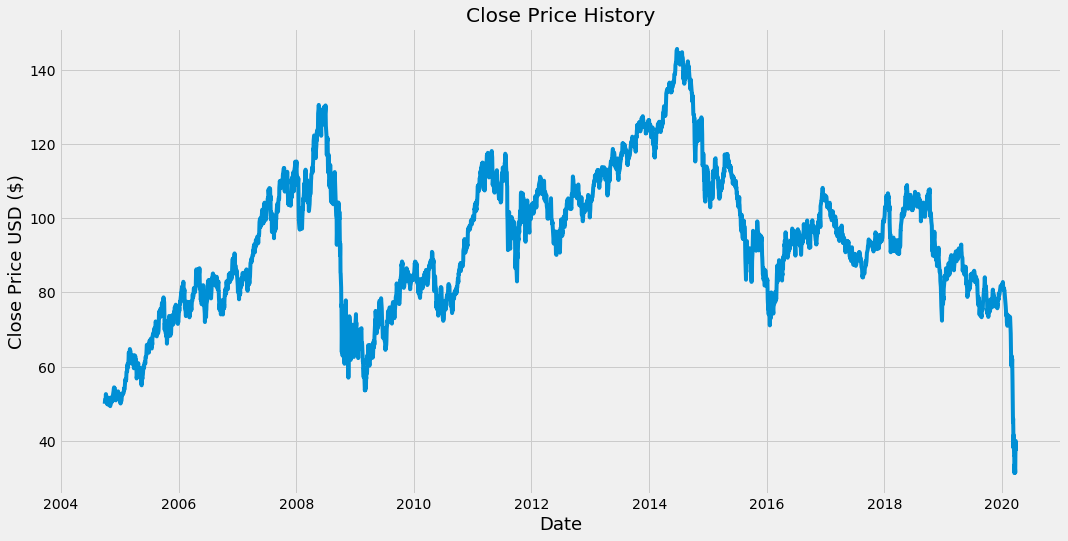

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(rawDataDF['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [6]:
# Create a new data frame with only the 'close' column
closePriceDF = rawDataDF.filter(['Close'])
# print(type(closePriceDF))
# print(closePriceDF)


# Convert the dataframe to a numpy array
#dataset = closePriceDF.values
closePriceArray = closePriceDF.values

# Get the number of rows to train the LSTM model on
# training_data_length will be 80% of the total
training_data_length = math.ceil(len(closePriceArray) * 0.8)

print('Dataset Length: ', len(closePriceArray))
print('Training Length:', training_data_length)


Dataset Length:  3901
Training Length: 3121


In [7]:
# Scale all of the close prices to be between 0 and one
scaler = MinMaxScaler(feature_range=(0,1))


In [8]:
# Prices before scaling
closePriceArray


array([[49.97000122],
       [50.41999817],
       [51.06999969],
       ...,
       [37.79999924],
       [39.95000076],
       [37.27000046]])

In [9]:
closePriceArrayScaled = scaler.fit_transform(closePriceArray)


In [10]:
# Prices after scaling
closePriceArrayScaled


array([[0.16341527],
       [0.16735191],
       [0.17303821],
       ...,
       [0.05695038],
       [0.0757589 ],
       [0.05231388]])

In [11]:
# Create training data from scaled data
# get the rows from 0 to training data length and
# get all the columns.
# train_data will now have 80% of the scaled data
train_data = closePriceArrayScaled[0:training_data_length , :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    # Append the past 60 values to our x_train dataset. 
    # i-60 is 0 the first time.
    # i Never reaches i. 
    # Get the 0th column which is the close price
    x_train.append(train_data[i-60:i, 0])
    # Get the 61st value
    # Get the 0th column which is the close price
    y_train.append(train_data[i, 0])
#     if i<=61:
#         print(x_train) # The past 60 values
#         print(y_train) # Contains the 61st value that we want the model to predict
#         print()


In [12]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [13]:
# Currently, our data is 2D:
print('x_train.shape:', x_train.shape)
x_train.shape


x_train.shape: (3061, 60)


(3061, 60)

In [14]:
# Reshape the data because an LSTM network expects the input to be 3 dimensional
# in the form of [Number of Samples, Number of Time Steps, Number of Features]


# x_train = np.reshape(x_train, (#rows, #steps, #features))
# x_train.shape[0] is the number of rows
# x_train.shape[1] is the number of columns which is the steps
# #features is 1, it's the closing price

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape


(3061, 60, 1)

In [15]:

model = Sequential()
# Start with 50 neurons
# return_sequences=True because we are going to use another LSTM layer
# Since this is the first layer, we need to provide an input shape
# which is the number of time steps and number of features
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# return_sequences=False because we are not going to add any more LSTM layers
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
# Train
# This limited training seems to give us decent results for now, but of course this could be expanded.
model.fit(x_train, y_train, batch_size=1, epochs=1)


Train on 3061 samples
3061/3061 [==============================] - 98s 32ms/sample - loss: 0.0016s -


In [18]:
# Create the testing data set
# Create a new array containing scaled values
test_data = closePriceArrayScaled[training_data_length - 60: , :]

# Create the data sets x_test and y_test
x_test = []
# y_test will be all of the values we want our model to predict
y_test = closePriceArray[training_data_length:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [19]:
# Convert to a numpy array so that we can use it in the LSTM model
x_test = np.array(x_test)


In [20]:
# Reshape the data from 2D to 3D because the LSTM model expects 3D shape
# Give it the number of rows/samples, the number of columns which is the number of time steps, and the close price.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [21]:
# Now we want to get the model's predicted price values

# We want it to be the exact same values that's in our y_test data set once we inverse transform the data
predictions = model.predict(x_test)

# Inverse transform the data
# We are "un-scaling" the values
predictions = scaler.inverse_transform(predictions)

# We want our predictions to contain the same values as our y_test dataset


In [22]:
# Evaluate model

# Get the RMSE

rmse = np.sqrt(np.mean(predictions - y_test)**2)


# 0 Would indicate perfect prediction
rmse


2.9298167815575233

C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


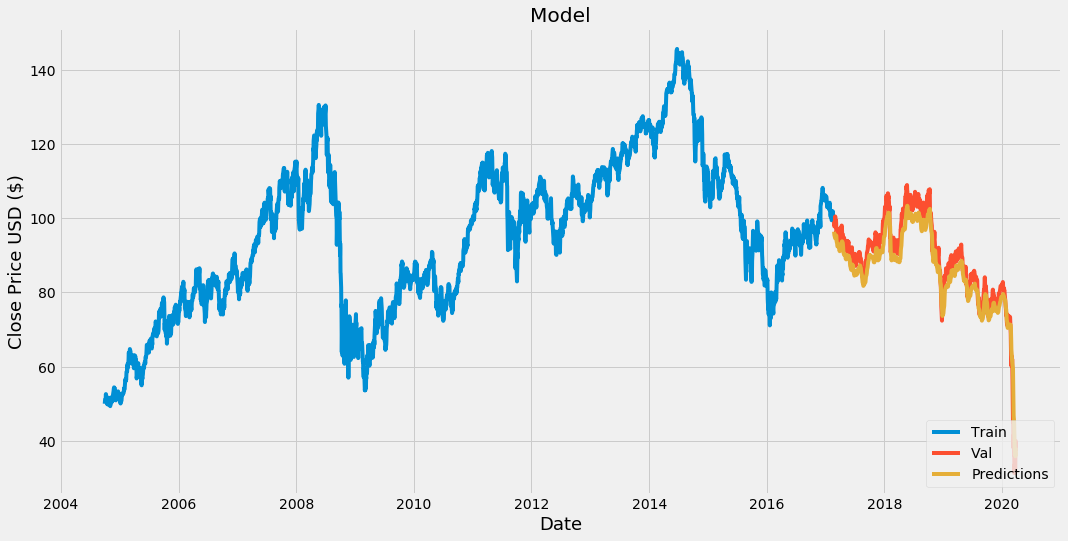

In [23]:
# Plot the data
train = closePriceDF[:training_data_length]
valid = closePriceDF[training_data_length:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [24]:
# Show the valid and predicted prices
valid


,Close,Predictions
Date,,
2017-02-22,98.480003,96.351418
2017-02-23,98.870003,95.831566
2017-02-24,97.760002,95.427879
2017-02-27,98.750000,94.920387
2017-02-28,98.370003,94.703735
...,...,...
2020-03-23,31.400000,36.629436
2020-03-24,36.340000,35.830666
2020-03-25,37.799999,36.007206


In [25]:
# Get a prediction for a particular day

# Get the quote
quote = web.DataReader('VDE', data_source='yahoo', start='2000-01-01',end='2020-03-26')
# Create a new dataframe
new_df = quote.filter(['Close'])
# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the last 60 days
#X_test = np.append(last_60_days_scaled)
X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print('Predicted Closing Price of VDE for 2020-03-27', pred_price)


Predicted Closing Price of VDE for 2020-03-27 [[38.114204]]


In [27]:
# Get the actual price
actualQuote = web.DataReader('VDE', data_source='yahoo', start='2020-03-27',end='2020-03-27')
print('Actual Closing Price of VDE for 2020-03-27', actualQuote['Close'])


Actual Closing Price of VDE for 2020-03-27 Date
2020-03-27    37.27
Name: Close, dtype: float64
